In [2]:
!pip install yfinance

In [3]:
import yfinance as yf

#downloading bitcoin price
train_data = yf.download("BTC-USD", start="2019-01-01", end="2024-01-01")
test_data = yf.download("BTC-USD", start="2024-01-01", end="2024-05-01")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
print(train_data)

                    Open          High           Low         Close  \
Date                                                                 
2019-01-01   3746.713379   3850.913818   3707.231201   3843.520020   
2019-01-02   3849.216309   3947.981201   3817.409424   3943.409424   
2019-01-03   3931.048584   3935.685059   3826.222900   3836.741211   
2019-01-04   3832.040039   3865.934570   3783.853760   3857.717529   
2019-01-05   3851.973877   3904.903076   3836.900146   3845.194580   
...                  ...           ...           ...           ...   
2023-12-27  42518.468750  43683.160156  42167.582031  43442.855469   
2023-12-28  43468.199219  43804.781250  42318.550781  42627.855469   
2023-12-29  42614.644531  43124.324219  41424.062500  42099.402344   
2023-12-30  42091.753906  42584.125000  41556.226562  42156.902344   
2023-12-31  42152.097656  42860.937500  41998.253906  42265.187500   

               Adj Close       Volume  
Date                                   
2019-01-0

In [5]:
print(test_data)

                    Open          High           Low         Close  \
Date                                                                 
2024-01-01  42280.234375  44175.437500  42214.976562  44167.332031   
2024-01-02  44187.140625  45899.707031  44176.949219  44957.968750   
2024-01-03  44961.601562  45503.242188  40813.535156  42848.175781   
2024-01-04  42855.816406  44770.023438  42675.175781  44179.921875   
2024-01-05  44192.980469  44353.285156  42784.718750  44162.691406   
...                  ...           ...           ...           ...   
2024-04-26  64485.371094  64789.656250  63322.398438  63755.320312   
2024-04-27  63750.988281  63898.363281  62424.718750  63419.140625   
2024-04-28  63423.515625  64321.484375  62793.597656  63113.230469   
2024-04-29  63106.363281  64174.878906  61795.457031  63841.121094   
2024-04-30  63839.417969  64703.332031  59120.066406  60636.855469   

               Adj Close       Volume  
Date                                   
2024-01-0

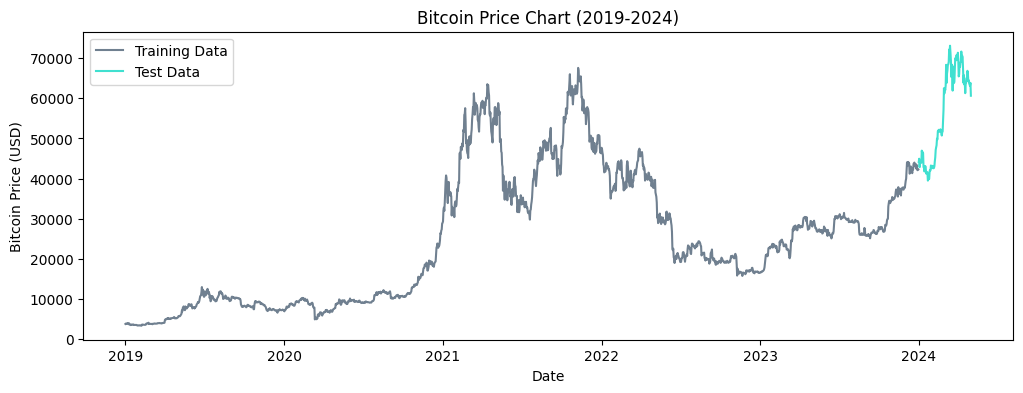

In [6]:
import matplotlib.pyplot as plt

# Plotting the Bitcoin price chart
plt.figure(figsize=(12, 4))
plt.plot(train_data.index, train_data['Close'], label='Training Data', color='slategray')
plt.plot(test_data.index, test_data['Close'], label='Test Data', color='turquoise')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.title('Bitcoin Price Chart (2019-2024)')
plt.legend()

# Show plot
plt.show()


In [7]:
# normalizing data
from sklearn.preprocessing import MinMaxScaler

# Extracting 'Close' prices (our target variable, y)
train_y = train_data['Close'].values.reshape(-1, 1)
test_y = test_data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
# Fit the scaler on training data only
scaler.fit(train_y)

# Transform both training and test data using the fitted scaler
train_y_scaled = scaler.transform(train_y)
test_y_scaled = scaler.transform(test_y)

In [8]:
print(train_y_scaled[:5])

[[0.00692016]
 [0.00847686]
 [0.00681452]
 [0.00714142]
 [0.00694626]]


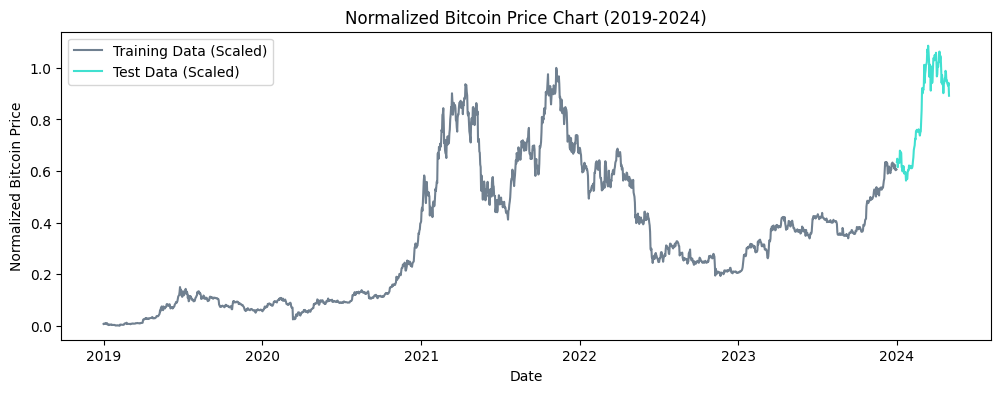

In [9]:
# Plotting the normalized Bitcoin price again
plt.figure(figsize=(12, 4))
plt.plot(train_data.index, train_y_scaled, label='Training Data (Scaled)', color='slategray')
plt.plot(test_data.index, test_y_scaled, label='Test Data (Scaled)', color='turquoise')

plt.xlabel('Date')
plt.ylabel('Normalized Bitcoin Price')
plt.title('Normalized Bitcoin Price Chart (2019-2024)')
plt.legend()

# Show plot
plt.show()

In [10]:
import numpy as np

# Defining number of past data points to consider for prediction
n_past = 60

# Initialize empty lists to store input sequences (X) and corresponding output values (y)
X_train = []
y_train = []

# Create sequences of length n_past for training
for i in range(n_past, len(train_y_scaled)):
    X_train.append(train_y_scaled[i - n_past:i, 0])  # Using past n_past values for the current prediction
    y_train.append(train_y_scaled[i, 0])

# Convert lists to numpy arrays and reshaping X_train for LSTM input (samples, time steps, features)
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)


X_train.shape: (1766, 60, 1)
y_train.shape: (1766,)


In [11]:
print(y_train[1])

0.006977131774846636


lets build LSTM model:


In [12]:
!pip install tensorflow

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model with 4 LSTM layers and dropout
def create_lstm_model(input_shape, dropout_rate=0.2):
    model = Sequential()

    # Add the first LSTM layer with dropout
    model.add(LSTM(units=50, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout_rate))

    # Add the second LSTM layer with dropout
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(dropout_rate))

    # Add the third LSTM layer with dropout
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(dropout_rate))

    # Add the fourth LSTM layer
    model.add(LSTM(units=50))

    # Add a Dense (fully connected) layer with 1 unit for regression output
    model.add(Dense(units=1))

    # Compile the model with mean squared error loss and Adam optimizer
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

# Create the LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])  # (time steps, features)
lstm_model = create_lstm_model(input_shape, dropout_rate=0.2)

# Display model summary
print(lstm_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [ ]:
history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
56/56 - 15s - loss: 0.0138 - 15s/epoch - 274ms/step
Epoch 2/100
56/56 - 7s - loss: 0.0034 - 7s/epoch - 127ms/step
Epoch 3/100
56/56 - 9s - loss: 0.0031 - 9s/epoch - 158ms/step
Epoch 4/100
56/56 - 7s - loss: 0.0028 - 7s/epoch - 120ms/step
Epoch 5/100
56/56 - 7s - loss: 0.0033 - 7s/epoch - 116ms/step
Epoch 6/100
56/56 - 7s - loss: 0.0028 - 7s/epoch - 118ms/step
Epoch 7/100
56/56 - 6s - loss: 0.0022 - 6s/epoch - 114ms/step
Epoch 8/100
56/56 - 7s - loss: 0.0024 - 7s/epoch - 117ms/step
Epoch 9/100
56/56 - 8s - loss: 0.0020 - 8s/epoch - 146ms/step
Epoch 10/100
56/56 - 6s - loss: 0.0022 - 6s/epoch - 106ms/step
Epoch 11/100
56/56 - 7s - loss: 0.0025 - 7s/epoch - 126ms/step
Epoch 12/100
56/56 - 6s - loss: 0.0023 - 6s/epoch - 106ms/step
Epoch 13/100
56/56 - 7s - loss: 0.0018 - 7s/epoch - 128ms/step
Epoch 14/100
56/56 - 6s - loss: 0.0018 - 6s/epoch - 107ms/step
Epoch 15/100
56/56 - 7s - loss: 0.0016 - 7s/epoch - 129ms/step
Epoch 16/100
56/56 - 6s - loss: 0.0014 - 6s/epoch - 105ms/step

2/2 [==============================] - 0s 36ms/step


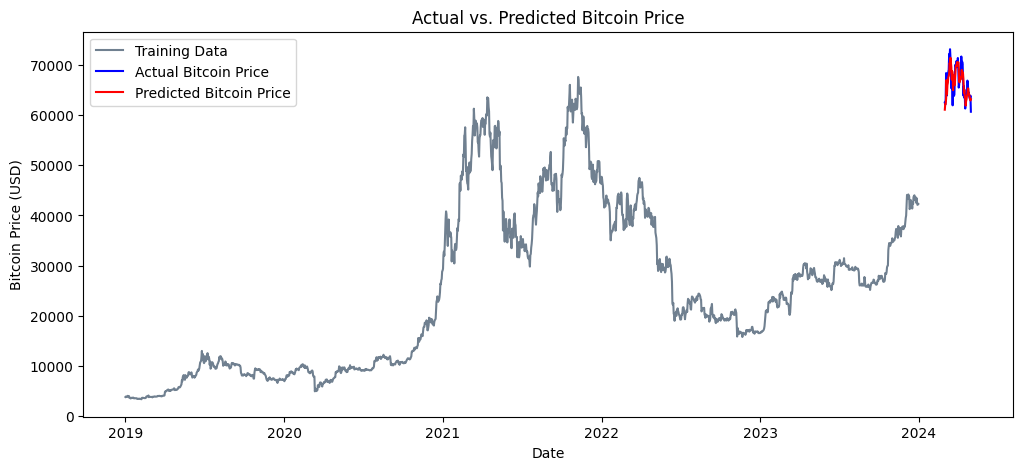

In [16]:
# using the trained LSTM model to make predictions on the test data
test_X = []

# Create sequences of length n_past for test data
for i in range(n_past, len(test_y_scaled)):
    test_X.append(test_y_scaled[i - n_past:i, 0])

# Convert test_X to numpy array and reshape for LSTM input
test_X = np.array(test_X)
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

predictions = lstm_model.predict(test_X)
predictions = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(test_y_scaled[n_past:, 0].reshape(-1, 1))

# Plot actual versus predicted values
plt.figure(figsize=(12, 5))
plt.plot(train_data.index, train_data['Close'], label='Training Data', color='slategray')
plt.plot(test_data.index[n_past:], actual_values, label='Actual Bitcoin Price', color='blue')
plt.plot(test_data.index[n_past:], predictions, label='Predicted Bitcoin Price', color='red')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.title('Actual vs. Predicted Bitcoin Price')
plt.legend()

# Show plot
plt.show()


used links:
https://aroussi.com/post/python-yahoo-finance


https://matplotlib.org/stable/gallery/color/named_colors.html

https://www.youtube.com/watch?v=b61DPVFX03I

